In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Load data

In [4]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
df_train.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [5]:
df_train.tail()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert
18523,18523,1.0,No,8.0,6.0,No,4.0,7.0,Extrovert


In [74]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [6]:
df_train.groupby('Stage_fear')['Time_spent_Alone'].describe()

,count,mean,std,min,25%,50%,75%,max
Stage_fear,,,,,,,,
No,11704.0,1.669942,1.356418,0.0,1.0,2.0,3.0,11.0
Yes,3785.0,7.345575,2.373434,0.0,5.0,7.0,9.0,11.0


In [7]:
df_train.groupby(['Stage_fear','Drained_after_socializing']).count()
#Highly correlated
#Keep stage_fear and drop Drained_after_socializing
#first impute null values of stage_fear from Drained_after_socializing

id  Time_spent_Alone  \
Stage_fear Drained_after_socializing                            
No         No                         12161             11271   
           Yes                           15                14   
Yes        No                            13                13   
           Yes                         3332              3112   

                                      Social_event_attendance  Going_outside  \
Stage_fear Drained_after_socializing                                           
No         No                                           11457          11248   
           Yes                                             15             15   
Yes        No                                              13             12   
           Yes                                           2933           2864   

                                      Friends_circle_size  Post_frequency  \
Stage_fear Drained_after_socializing                                        
No         No                                       11504           11423   
           Yes                                         13              14   
Yes        No                                          13              11   
           Yes                                       3009            2886   

                                      Personality  
Stage_fear Drained_after_socializing               
No         No                               12161  
           Yes                                 15  
Yes        No                                  13  
           Yes                               3332

In [8]:
#Impute Time_spent_Alone for NaN values
#Impute to 0 or mean, imputing overall mean may be misleading, impute based on Stage_fear or Drained_after_socializing given data above
#However check the correlation of the Stage_fear with target
#Since it is correlated with target, this imputation method introduces bias
#We are amplifying that signal, even where the true value is unknown — which can lead to overfitting and inflated model performance on validation

In [9]:
#Impute with group mean with a missing indicator column
# df_train['Time_spent_Alone_Missing'] = df_train['Time_spent_Alone'].isna()
# mean_Stage_fear = df_train.groupby('Stage_fear')['Time_spent_Alone'].transform('mean')
# df_train['Time_spent_Alone'] = df_train['Time_spent_Alone'].fillna(mean_Stage_fear)

In [10]:
#Alternatively impute with constant mean with a missing indicator column
#Avoids bias
def impute_mean(col, df):
    missing_indicator = col + 'Missing'
    df[missing_indicator] = df[col].isna().astype(int)
    mean_col = df[col].mean()
    df[col] = df[col].fillna(mean_col)

impute_mean('Time_spent_Alone', df_train)

In [11]:
df_train.groupby('Stage_fear')['Social_event_attendance'].describe()
#mean_Social_event_attendance = df_test.groupby('Stage_fear')['Social_event_attendance'].transform('mean')
#df_test['Social_event_attendance'] = df_test['Social_event_attendance'].fillna(mean_Social_event_attendance)

,count,mean,std,min,25%,50%,75%,max
Stage_fear,,,,,,,,
No,11898.0,6.468650,1.941413,0.0,5.0,6.0,8.0,10.0
Yes,3603.0,1.635581,1.271622,0.0,1.0,2.0,3.0,9.0


In [12]:
#Impute 'Social_event_attendance'

impute_mean('Social_event_attendance', df_train)

In [13]:
df_train[df_train['Social_event_attendanceMissing']==True].head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Time_spent_AloneMissing,Social_event_attendanceMissing
13,13,3.0,NaN,5.265106,5.0,No,12.0,5.0,Extrovert,0,1
19,19,1.0,No,5.265106,5.0,No,10.0,3.0,Extrovert,0,1
28,28,2.0,No,5.265106,4.0,No,5.0,8.0,Extrovert,0,1
50,50,7.0,Yes,5.265106,2.0,Yes,5.0,2.0,Introvert,0,1
67,67,3.0,No,5.265106,7.0,No,6.0,9.0,Extrovert,0,1


In [14]:
impute_mean('Going_outside', df_train)

In [15]:
df_train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Time_spent_AloneMissing,Social_event_attendanceMissing,Going_outsideMissing
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,0,0,0
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,0,0,0
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert,0,0,0
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert,0,0,0
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert,0,0,0


In [16]:
impute_mean('Friends_circle_size', df_train)
impute_mean('Post_frequency', df_train)

In [17]:
#Transform the binary columns
binary_cols = ['Stage_fear','Drained_after_socializing']
df_train[binary_cols] = df_train[binary_cols].replace({'Yes':1,'No':0})

/tmp/ipykernel_35/1909159999.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[binary_cols] = df_train[binary_cols].replace({'Yes':1,'No':0})


In [18]:
df_train.describe()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_AloneMissing,Social_event_attendanceMissing,Going_outsideMissing,Friends_circle_sizeMissing,Post_frequencyMissing
count,18524.000000,18524.000000,16631.000000,18524.000000,18524.000000,17375.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000
mean,9261.500000,3.137764,0.241838,5.265106,4.044319,0.233784,7.996737,4.982097,0.064241,0.063701,0.079141,0.056899,0.068236
std,5347.562529,2.905696,0.428209,2.664215,1.979276,0.423249,4.101561,2.779168,0.245188,0.244226,0.269965,0.231656,0.252157
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9261.500000,3.000000,0.000000,5.265106,4.000000,0.000000,8.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13892.250000,4.000000,0.000000,7.000000,6.000000,0.000000,11.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18523.000000,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
df_train[df_train['Stage_fear'].isna()]

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Time_spent_AloneMissing,Social_event_attendanceMissing,Going_outsideMissing,Friends_circle_sizeMissing,Post_frequencyMissing
13,13,3.0,NaN,5.265106,5.0,0.0,12.0,5.0,Extrovert,0,1,0,0,0
17,17,5.0,NaN,0.000000,4.0,1.0,2.0,0.0,Introvert,0,0,0,0,0
22,22,4.0,NaN,0.000000,1.0,1.0,2.0,0.0,Introvert,0,0,0,0,0
26,26,3.0,NaN,6.000000,5.0,0.0,10.0,9.0,Extrovert,0,0,0,0,0
27,27,9.0,NaN,0.000000,0.0,1.0,1.0,1.0,Introvert,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18498,18498,3.0,NaN,5.000000,5.0,0.0,15.0,7.0,Extrovert,0,0,0,0,0
18504,18504,2.0,NaN,8.000000,5.0,0.0,11.0,3.0,Extrovert,0,0,0,0,0
18507,18507,3.0,NaN,6.000000,6.0,0.0,14.0,5.0,Extrovert,0,0,0,0,0
18518,18518,3.0,NaN,8.000000,3.0,0.0,5.0,8.0,Extrovert,0,0,0,0,0


In [20]:
df_target = df_train['Personality']
df_train = df_train.drop('Personality',axis=1)

In [21]:
#Correlation coefficient
corr = df_train.corr()

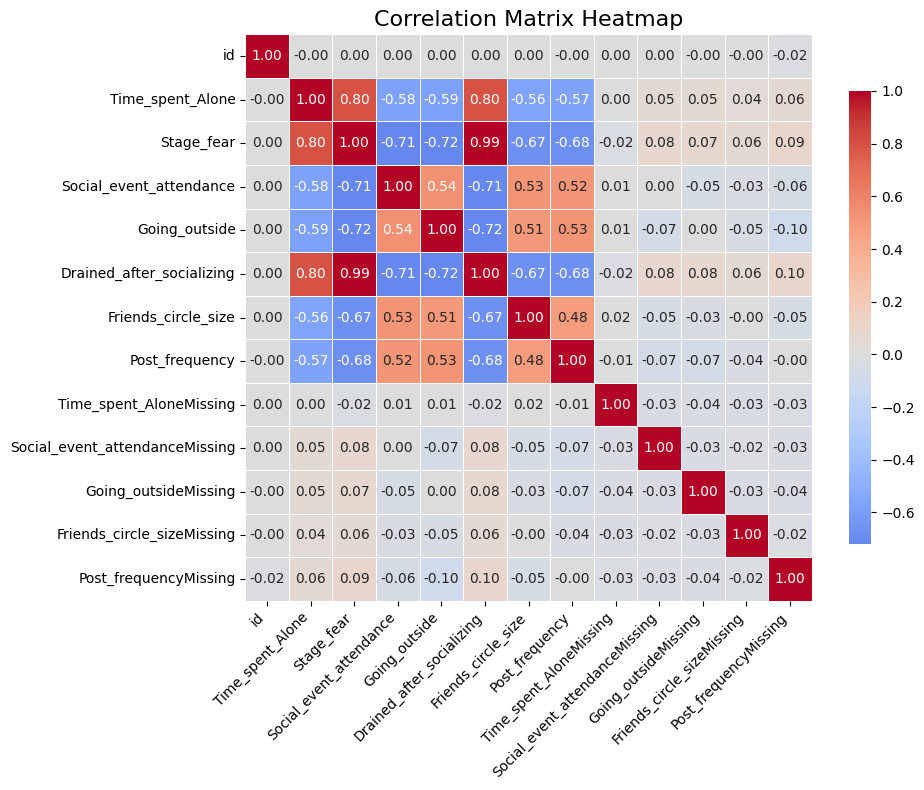

In [22]:
plt.figure(figsize=(10, 8)) 

sns.heatmap(
    corr,
    annot=True,            
    fmt=".2f",             
    cmap='coolwarm',       
    center=0,              
    square=True,           
    linewidths=0.5,        
    cbar_kws={'shrink': 0.8}
)

plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
#Since highly correlated, use col to impute and drop Drained_after_socializing due to high correlation
df_train['Stage_fear'] = df_train['Stage_fear'].fillna(df_train['Drained_after_socializing'])
#rest impute with 0
df_train['Stage_fear'] = df_train['Stage_fear'].fillna(0)

In [24]:
df_train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_AloneMissing,Social_event_attendanceMissing,Going_outsideMissing,Friends_circle_sizeMissing,Post_frequencyMissing
0,0,0.0,0.0,6.0,4.0,0.0,15.0,5.000000,0,0,0,0,0
1,1,1.0,0.0,7.0,3.0,0.0,10.0,8.000000,0,0,0,0,0
2,2,6.0,1.0,1.0,0.0,NaN,3.0,0.000000,0,0,0,0,0
3,3,3.0,0.0,7.0,3.0,0.0,11.0,5.000000,0,0,0,0,0
4,4,1.0,0.0,4.0,4.0,0.0,13.0,4.982097,0,0,0,0,1


In [25]:
df_train[['Time_spent_Alone','Stage_fear','Social_event_attendance','Going_outside','Friends_circle_size','Post_frequency',
'Time_spent_AloneMissing','Social_event_attendanceMissing','Going_outsideMissing','Friends_circle_sizeMissing',	'Post_frequencyMissing']].head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Time_spent_AloneMissing,Social_event_attendanceMissing,Going_outsideMissing,Friends_circle_sizeMissing,Post_frequencyMissing
0,0.0,0.0,6.0,4.0,15.0,5.000000,0,0,0,0,0
1,1.0,0.0,7.0,3.0,10.0,8.000000,0,0,0,0,0
2,6.0,1.0,1.0,0.0,3.0,0.000000,0,0,0,0,0
3,3.0,0.0,7.0,3.0,11.0,5.000000,0,0,0,0,0
4,1.0,0.0,4.0,4.0,13.0,4.982097,0,0,0,0,1


In [26]:
X = df_train[['Time_spent_Alone','Stage_fear','Social_event_attendance','Going_outside','Friends_circle_size','Post_frequency',
'Time_spent_AloneMissing','Social_event_attendanceMissing','Going_outsideMissing','Friends_circle_sizeMissing',	'Post_frequencyMissing']]

y = df_target.replace({'Extrovert':1,'Introvert':0})
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/tmp/ipykernel_35/2388246704.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_target.replace({'Extrovert':1,'Introvert':0})


In [27]:
pd.DataFrame(y).describe()

,Personality
count,18524.000000
mean,0.739527
std,0.438905
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [28]:
#Scale data
col_scale = ['Time_spent_Alone','Social_event_attendance',	'Going_outside','Friends_circle_size','Post_frequency']

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), col_scale)
    ],
    remainder='passthrough' 
)

In [29]:
X_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [30]:
pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.395140,-0.467151,0.483452,-0.494034,0.008349,0.0,0.0,0.0,0.0,0.0,0.0
1,0.293216,-0.841557,-1.033747,-1.469659,-0.712523,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.395140,1.030477,-0.022281,1.701122,1.089658,0.0,0.0,0.0,0.0,0.0,0.0
3,0.293216,1.030477,-0.022281,0.725497,0.008349,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.395140,1.404884,-0.528014,0.481591,0.368785,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#Try base model Logistic Regression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_model = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [32]:
#lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [33]:
print("Best Parameters:", lr_model.best_params_)

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [34]:
y_pred = lr_model.predict(X_test_scaled)

In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9671777153962428


In [36]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[1123   89]
 [  63 3356]]


In [37]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1212
           1       0.97      0.98      0.98      3419

    accuracy                           0.97      4631
   macro avg       0.96      0.95      0.96      4631
weighted avg       0.97      0.97      0.97      4631



In [38]:
#ROC AUC
y_proba = lr_model.predict_proba(X_test_scaled)[:,1]
auc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.9562804006343892


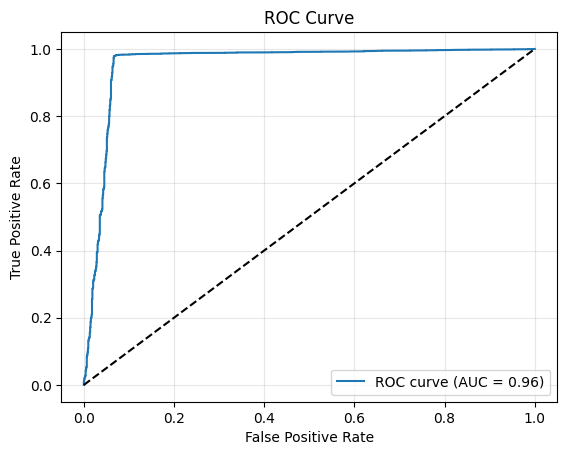

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

In [60]:
#Try Random Forest, XG Boost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
#rf_model = GridSearchCV(rf, param, cv=5, scoring='roc_auc', n_jobs=-1)
rf_model = RandomizedSearchCV(
    rf, param_distributions=param,
    n_iter=20, cv=5, scoring='accuracy',
    random_state=42, n_jobs=-1
)
rf_model.fit(X_scaled, y_train)

print("Best Random Forest Params:", rf_model.best_params_)

Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}


In [ ]:
#Best Random Forest Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
#Use this -- Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}

In [71]:
y_pred_rf = rf_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.96825739581084


In [63]:
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:,1]
auc_score_rf = roc_auc_score(y_test, y_proba_rf)
print("ROC AUC Score:", auc_score_rf)

ROC AUC Score: 0.9648162278936289


In [72]:
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

param = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xg_model = RandomizedSearchCV(
    xgb,
    param_distributions=param,
    n_iter=30,  # try 30 random combinations
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)
xg_model.fit(X_scaled, y_train)
print("Best XG Boost Params:", xg_model.best_params_)

Best XG Boost Params: {'colsample_bytree': 0.7265477506155757, 'learning_rate': 0.06879485872574355, 'max_depth': 3, 'n_estimators': 89, 'subsample': 0.9533601546034454}


In [70]:
y_pred_xg = xg_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_xg))

Accuracy: 0.9673936514791621


## Score Test dataset

In [73]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert


In [75]:
impute_mean('Time_spent_Alone', df_test)
impute_mean('Social_event_attendance', df_test)
impute_mean('Going_outside', df_test)
impute_mean('Friends_circle_size',df_test)
impute_mean('Post_frequency', df_test)
df_test[binary_cols] = df_test[binary_cols].replace({'Yes':1,'No':0})
df_test['Stage_fear'] = df_test['Stage_fear'].fillna(df_train['Drained_after_socializing'])
df_test['Stage_fear'] = df_test['Stage_fear'].fillna(0)

test = df_test[['Time_spent_Alone','Stage_fear','Social_event_attendance','Going_outside','Friends_circle_size','Post_frequency',
'Time_spent_AloneMissing','Social_event_attendanceMissing','Going_outsideMissing','Friends_circle_sizeMissing',	'Post_frequencyMissing']]

test_scaled = preprocessor.transform(test)


#y = df_target.replace({'Extrovert':1,'Introvert':0})

/tmp/ipykernel_35/3880986112.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[binary_cols] = df_test[binary_cols].replace({'Yes':1,'No':0})


In [84]:
pred_rf = rf_model.predict(test_scaled)

pred = pd.DataFrame(pred_rf,columns=['Personality'])
pred = pred.replace({1:'Extrovert',0:'Introvert'})
pred.head()

,Personality
0,Extrovert
1,Introvert
2,Extrovert
3,Extrovert
4,Introvert


In [88]:
#Submission
submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')
submission['Personality'] = pred['Personality']
submission.to_csv('submission.csv' ,index=False)
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
